# nnInteractive ONNX Model Demo

This notebook demonstrates how to use the exported ONNX model of nnInteractive for medical image segmentation. It covers:
1. Loading the ONNX model
2. Preparing medical image input
3. Creating point interactions
4. Running inference
5. Visualizing results

Make sure you've activated the correct conda environment with:
```bash
source /software/anaconda3/etc/profile.d/conda.sh
conda activate nnInteractive
```

In [7]:
import numpy as np
import onnxruntime as ort
import SimpleITK as sitk
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline

# Set paths
ONNX_MODEL_PATH = "/nfs/norasys/notebooks/camaret/model_checkpoints/nnInteractive_v1.0.onnx"
IMAGE_FILENAME = "/nfs/data/nii/data1/Analysis/GPUnet/ANALYSIS_incontext/amos22/amos22/imagesVa/amos_0311.nii.gz"

# Load the ONNX model
session = ort.InferenceSession(ONNX_MODEL_PATH)

print(f"✅ ONNX model loaded from {ONNX_MODEL_PATH}")

✅ ONNX model loaded from /nfs/norasys/notebooks/camaret/model_checkpoints/nnInteractive_v1.0.onnx


## Load and Preprocess the Medical Image

First, we load the medical image and preprocess it to fit the model's expected input dimensions.

In [8]:
# Helper function for resizing 3D medical images
def resize_preserve_content(arr, target_shape):
    """Resize array to target shape using interpolation to preserve content."""
    # Calculate zoom factors for each dimension
    factors = [t/s for t, s in zip(target_shape, arr.shape)]
    
    # Apply zoom with interpolation
    return zoom(arr, factors, order=1)

# Load the medical image using SimpleITK
input_image = sitk.ReadImage(IMAGE_FILENAME)
img_array = sitk.GetArrayFromImage(input_image)[None]  # Add batch dimension: (1, depth, height, width)

print(f"Original image shape: {img_array.shape}")

# Resize to model's expected dimensions: (1, 64, 128, 128)
img_resized = resize_preserve_content(img_array, (1, 64, 128, 128))

# Normalize pixel values to 0-1 range
img_min, img_max = img_resized.min(), img_resized.max()
if img_max > img_min:
    img_normalized = (img_resized - img_min) / (img_max - img_min)
else:
    img_normalized = img_resized

print(f"Preprocessed image shape: {img_normalized.shape}")
print(f"Value range: [{img_normalized.min():.2f}, {img_normalized.max():.2f}]")

Original image shape: (1, 198, 512, 512)
Preprocessed image shape: (1, 64, 128, 128)
Value range: [0.00, 1.00]


## Visualize the Preprocessed Image

Let's visualize the preprocessed image to verify it looks correct.

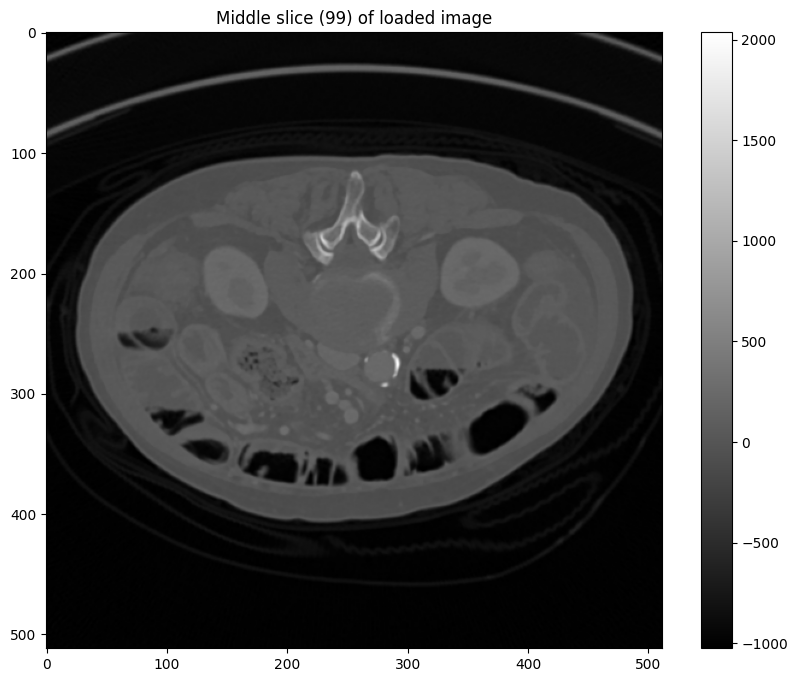

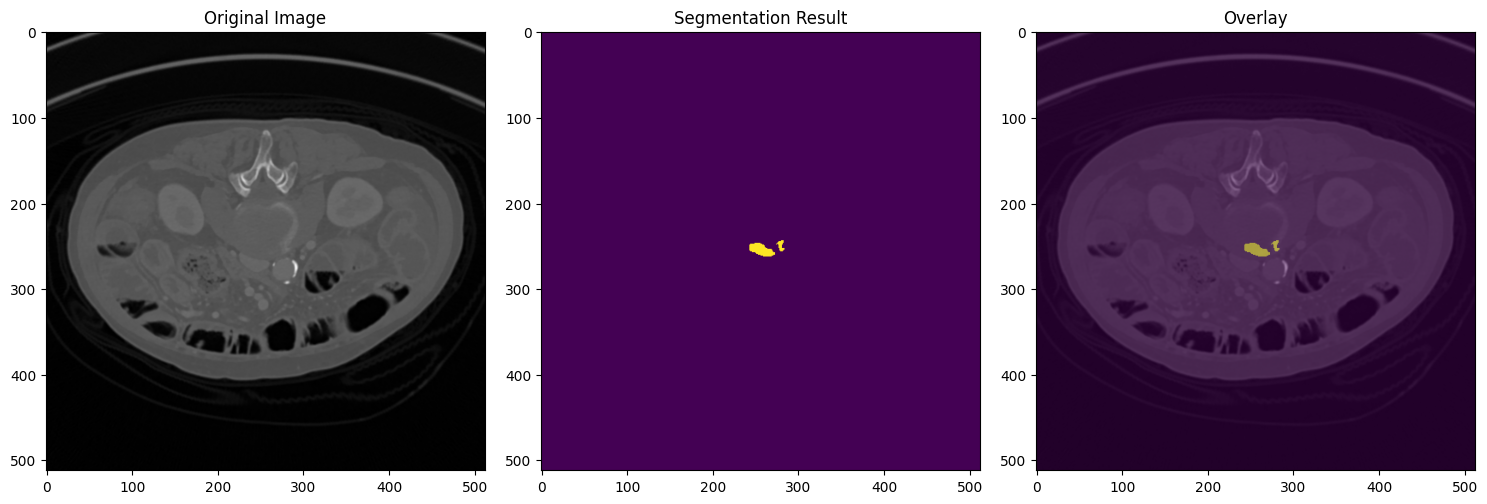

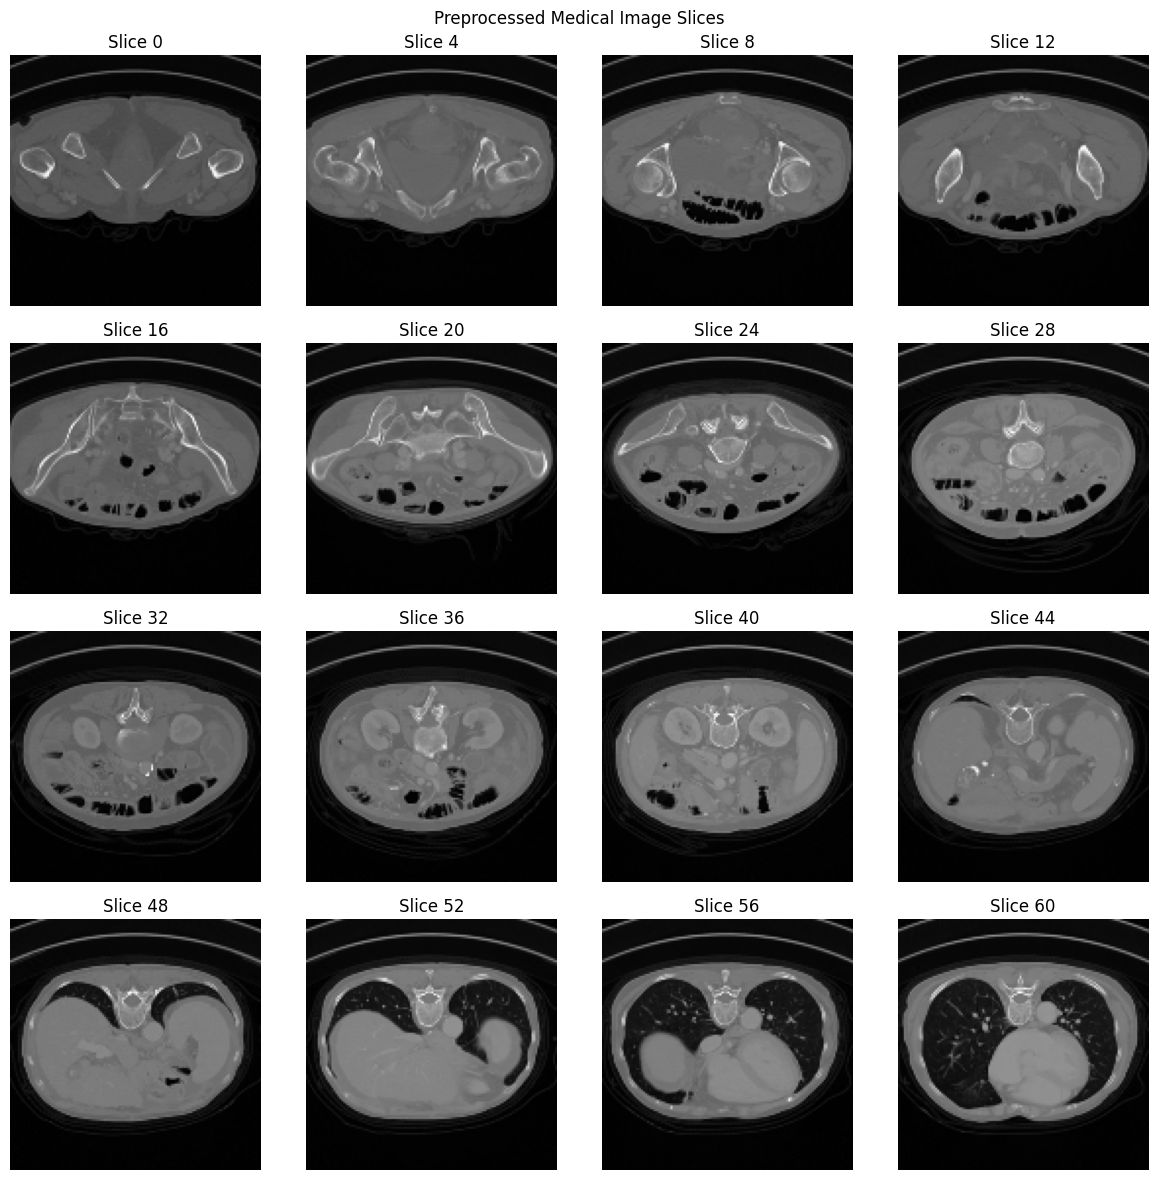

In [9]:
# Helper function to visualize multiple slices
def visualize_slices(volume, num_slices=16, title="Volume Slices"):
    plt.figure(figsize=(12, 12))
    rows, cols = 4, 4
    for i in range(min(num_slices, rows*cols)):
        slice_idx = i * (volume.shape[0] // num_slices)
        plt.subplot(rows, cols, i+1)
        plt.imshow(volume[slice_idx], cmap='gray')
        plt.title(f"Slice {slice_idx}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    
# Visualize slices
visualize_slices(img_normalized[0], title="Preprocessed Medical Image Slices")

## Prepare Input for ONNX Model

The nnInteractive ONNX model expects input in a specific format:
- Shape: (1, 8, 64, 128, 128)
- Channel 0: Image data
- Channel 4: Positive point interactions
- Channel 5: Negative point interactions
- Other channels: Used for different interaction types (bounding boxes, scribbles, etc.)

In [10]:
# Create input tensor with the correct shape
model_input = np.zeros((1, 8, 64, 128, 128), dtype=np.float32)

# Set the image in channel 0
model_input[0, 0, :, :, :] = img_normalized[0]

# Add a point interaction at a location where there's likely tissue to segment
# Format is (z, y, x) - adjust these coordinates based on your specific image
point_coords = (32, 64, 64)  # Center point
model_input[0, 4, point_coords[0], point_coords[1], point_coords[2]] = 1.0  # Channel 4 for positive points

print(f"Model input prepared with shape: {model_input.shape}")
print(f"Point interaction added at: {point_coords}")

Model input prepared with shape: (1, 8, 64, 128, 128)
Point interaction added at: (32, 64, 64)


## Run Inference with ONNX Model

Now we'll run the inference using our prepared input.

In [11]:
# Run inference
outputs = session.run(None, {'combined_input': model_input})

# Process output
output_tensor = outputs[0]  # Shape should be (1, 2, 64, 128, 128)
print(f"Output shape: {output_tensor.shape}")

# Convert to segmentation mask using argmax (class with highest probability)
# Since this is likely a binary segmentation, output should have 2 channels
segmentation = np.argmax(output_tensor[0], axis=0)
print(f"Segmentation mask shape: {segmentation.shape}")
print(f"Unique values in segmentation: {np.unique(segmentation)}")

Output shape: (1, 2, 64, 128, 128)
Segmentation mask shape: (64, 128, 128)
Unique values in segmentation: [0 1]


## Visualize Results

Let's visualize the results of our inference.

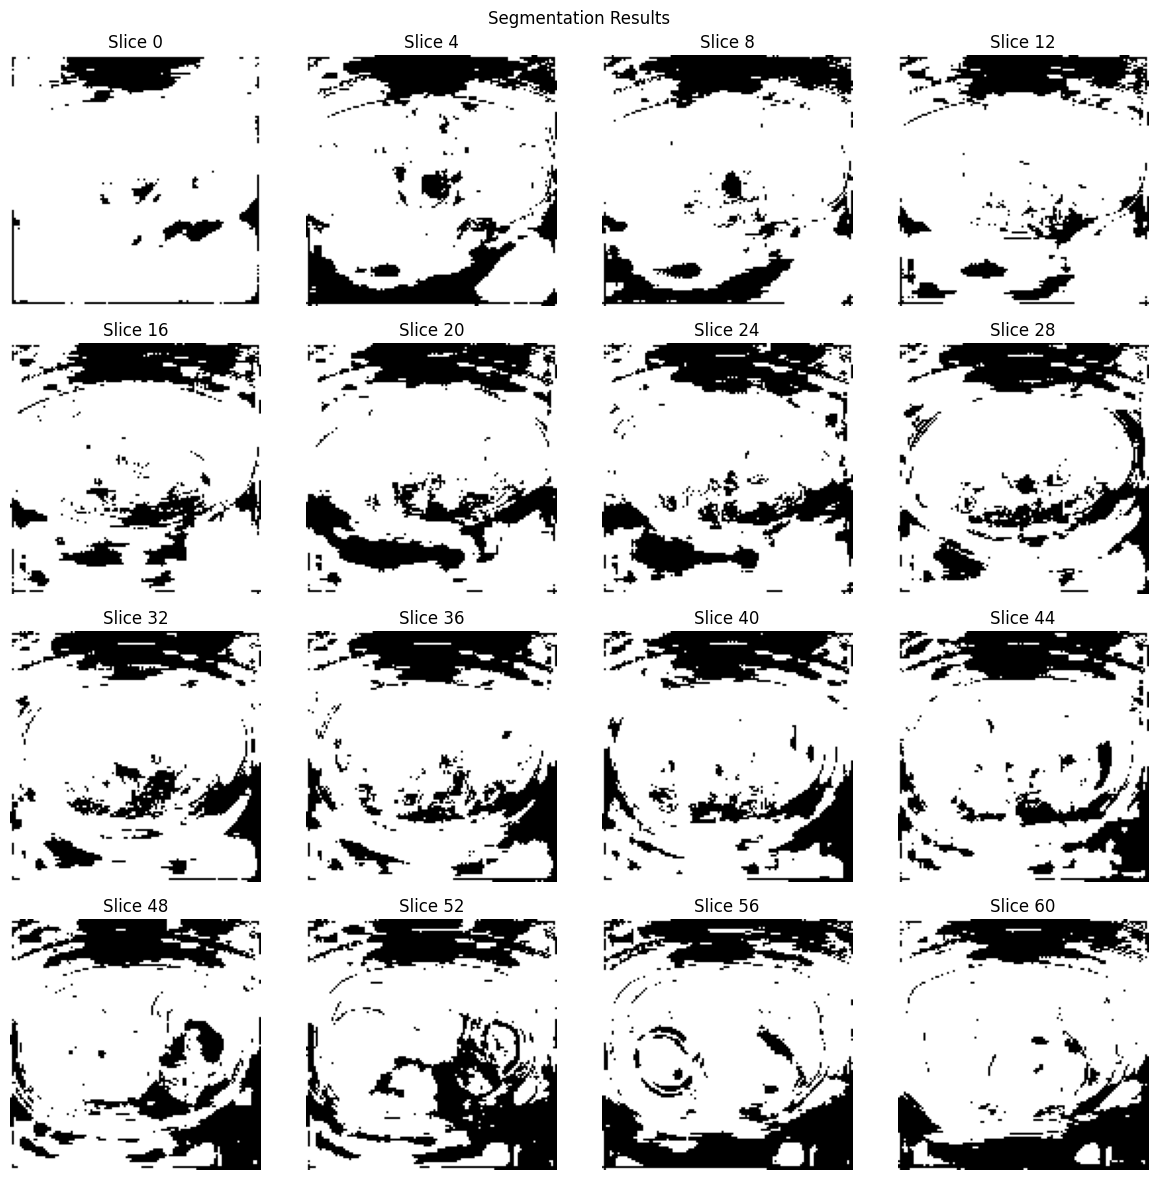

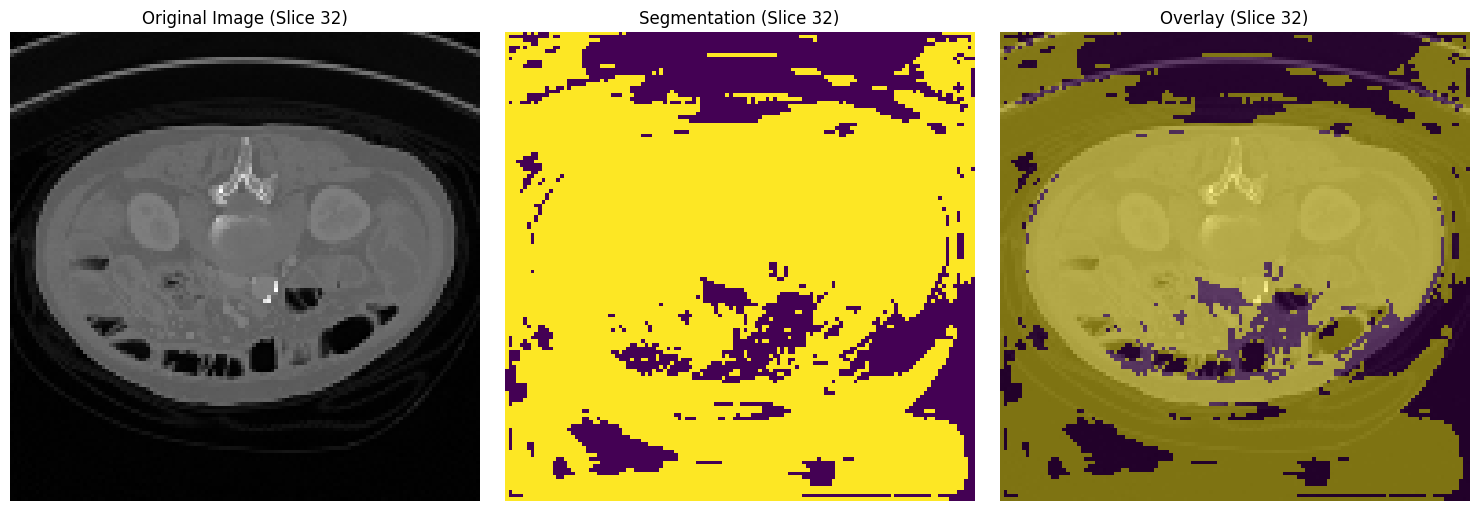

In [12]:
# Visualize segmentation results
visualize_slices(segmentation, title="Segmentation Results")

# Let's also check the slice where we placed the point interaction
z_point = point_coords[0]

plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.title(f"Original Image (Slice {z_point})")
plt.imshow(img_normalized[0, z_point], cmap='gray')
plt.axis('off')

# Segmentation mask
plt.subplot(132)
plt.title(f"Segmentation (Slice {z_point})")
plt.imshow(segmentation[z_point], cmap='viridis')
plt.axis('off')

# Overlay
plt.subplot(133)
plt.title(f"Overlay (Slice {z_point})")
plt.imshow(img_normalized[0, z_point], cmap='gray')
plt.imshow(segmentation[z_point], cmap='viridis', alpha=0.5)
plt.axis('off')

plt.tight_layout()
plt.show()

## Try Different Point Interactions

Now let's try adding a point interaction at a different location to see how it affects the segmentation.

Running inference with point at (20, 64, 64)...
Running inference with point at (40, 64, 64)...
Running inference with point at (60, 64, 64)...


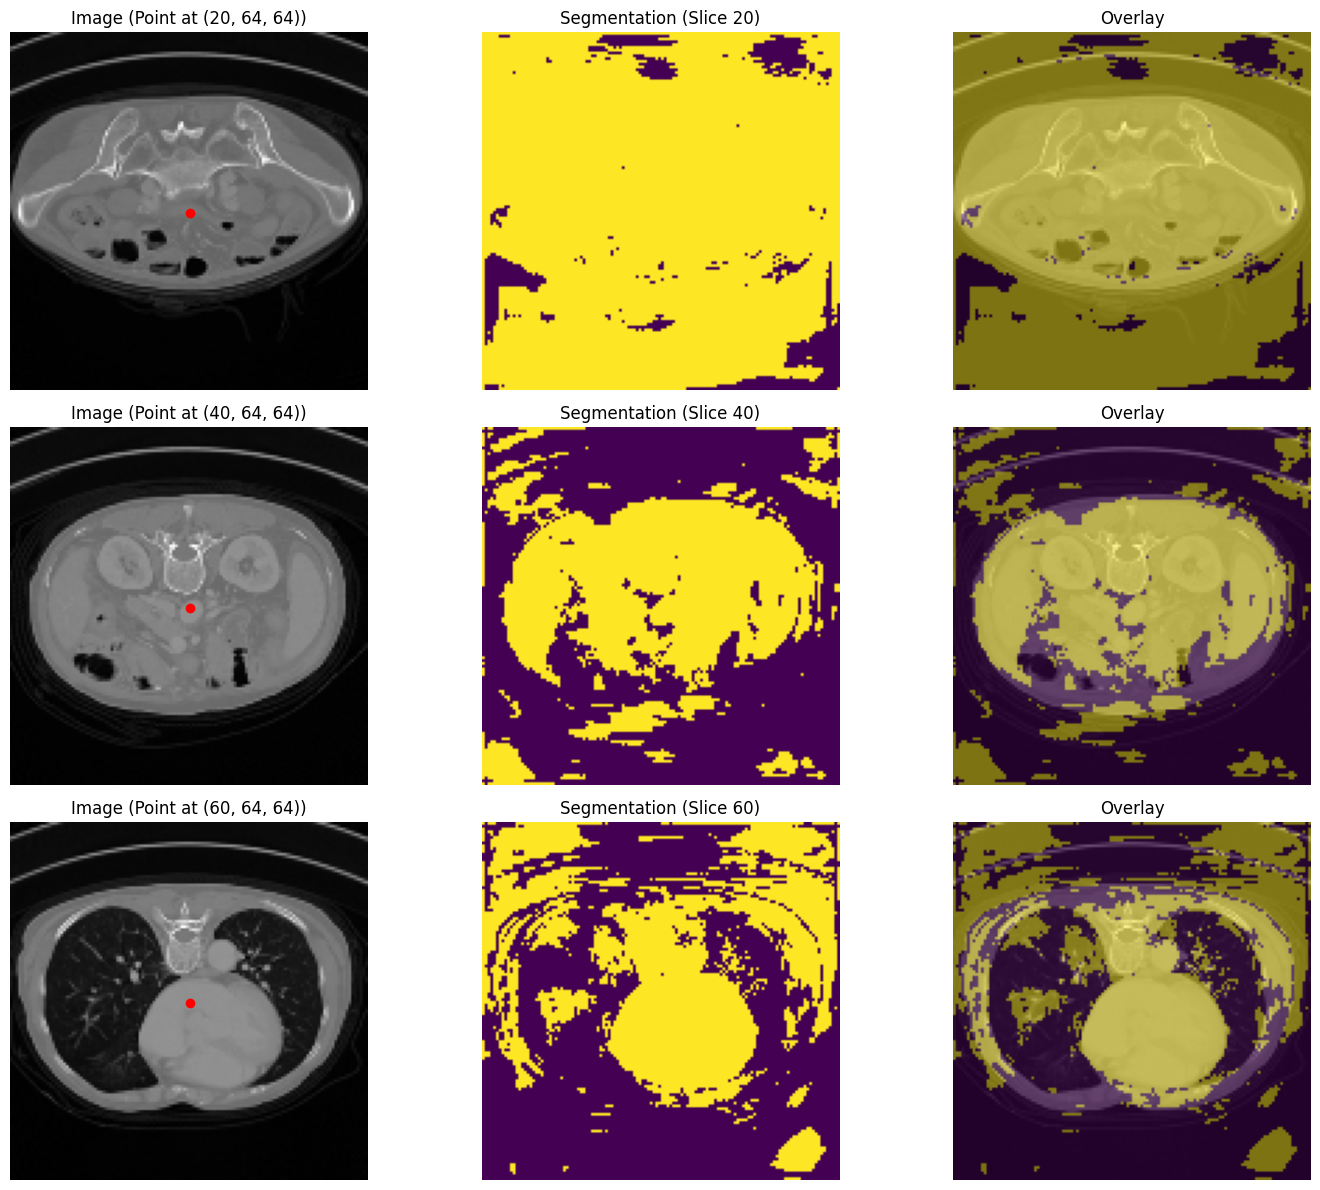

In [13]:
# Function to run inference with point interaction
def run_inference_with_point(image, point_coords):
    # Create input tensor
    point_input = np.zeros((1, 8, 64, 128, 128), dtype=np.float32)
    
    # Set the image in channel 0
    point_input[0, 0, :, :, :] = image[0]
    
    # Add point interaction
    point_input[0, 4, point_coords[0], point_coords[1], point_coords[2]] = 1.0
    
    # Run inference
    outputs = session.run(None, {'combined_input': point_input})
    
    # Process output
    segmentation = np.argmax(outputs[0][0], axis=0)
    
    return segmentation

# Try different point coordinates
points = [
    (20, 64, 64),  # Upper region
    (40, 64, 64),  # Middle region
    (60, 64, 64)   # Lower region
]

# Run inference for each point
results = []
for i, point in enumerate(points):
    print(f"Running inference with point at {point}...")
    seg = run_inference_with_point(img_normalized, point)
    results.append(seg)
    
# Visualize results
plt.figure(figsize=(15, 12))

for i, (point, result) in enumerate(zip(points, results)):
    z = point[0]
    
    # Input image
    plt.subplot(3, 3, i*3 + 1)
    plt.title(f"Image (Point at {point})")
    plt.imshow(img_normalized[0, z], cmap='gray')
    plt.plot(point[2], point[1], 'ro')  # Mark the point
    plt.axis('off')
    
    # Segmentation
    plt.subplot(3, 3, i*3 + 2)
    plt.title(f"Segmentation (Slice {z})")
    plt.imshow(result[z], cmap='viridis')
    plt.axis('off')
    
    # Overlay
    plt.subplot(3, 3, i*3 + 3)
    plt.title(f"Overlay")
    plt.imshow(img_normalized[0, z], cmap='gray')
    plt.imshow(result[z], cmap='viridis', alpha=0.5)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Advanced: Combine Multiple Interactions

Now let's demonstrate combining multiple interactions in a single input.

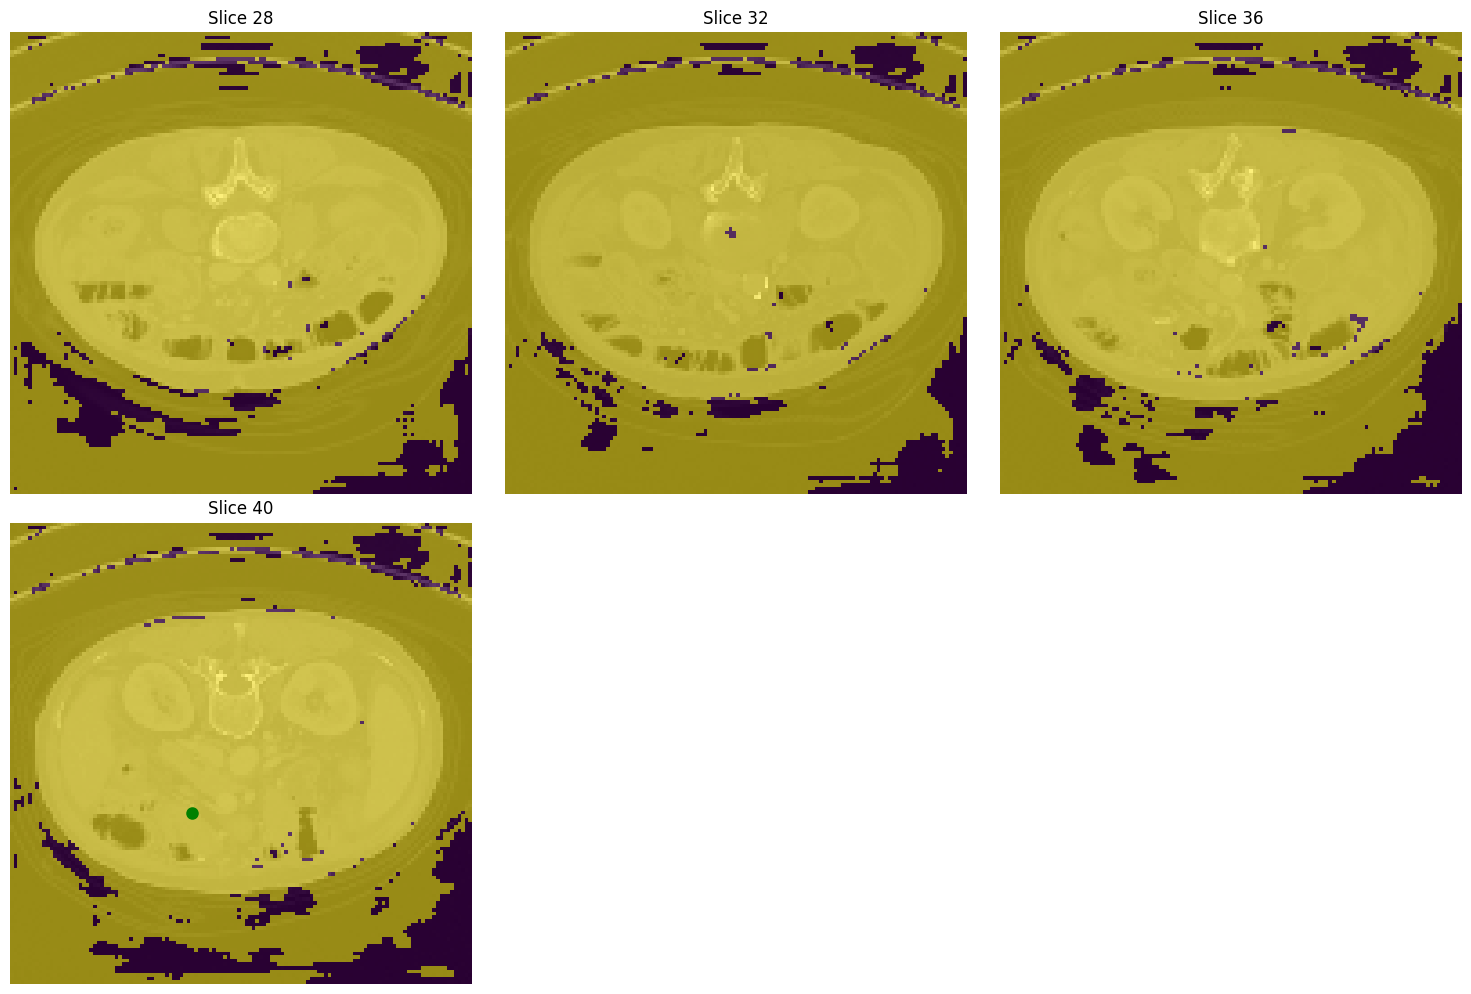

In [14]:
# Create an input with multiple interactions
multi_input = np.zeros((1, 8, 64, 128, 128), dtype=np.float32)
multi_input[0, 0, :, :, :] = img_normalized[0]  # Set image

# Add multiple positive points
positive_points = [(30, 70, 60), (35, 60, 70), (40, 80, 50)]
for z, y, x in positive_points:
    multi_input[0, 4, z, y, x] = 1.0  # Channel 4 for positive points

# Add a negative point to exclude some region
negative_points = [(30, 40, 40)]
for z, y, x in negative_points:
    multi_input[0, 5, z, y, x] = 1.0  # Channel 5 for negative points

# Run inference with multiple interactions
multi_outputs = session.run(None, {'combined_input': multi_input})
multi_segmentation = np.argmax(multi_outputs[0][0], axis=0)

# Visualize results
plt.figure(figsize=(15, 10))

# Show a few slices around where we placed points
for i, z in enumerate(range(28, 43, 4)):
    plt.subplot(2, 3, i+1)
    
    # Show the image with the segmentation overlay
    plt.imshow(img_normalized[0, z], cmap='gray')
    plt.imshow(multi_segmentation[z], cmap='viridis', alpha=0.6)
    
    # Mark the points
    for pz, py, px in positive_points:
        if pz == z:
            plt.plot(px, py, 'go', markersize=8)  # Green for positive
    
    for nz, ny, nx in negative_points:
        if nz == z:
            plt.plot(nx, ny, 'ro', markersize=8)  # Red for negative
            
    plt.title(f"Slice {z}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated how to use the nnInteractive ONNX model for interactive medical image segmentation. Key points:

1. The ONNX model input must have shape (1, 8, 64, 128, 128)
2. Medical images must be preprocessed to fit this shape
3. Channel 0 contains the normalized image data
4. Channel 4 is used for positive point interactions
5. Channel 5 is used for negative point interactions
6. Multiple interactions can be combined in a single inference

For more complex use cases, refer to the original nnInteractive implementation.